### Required Libraries

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
import pickle

### Dataset

In [106]:
# dataset path
datasetPath = './DataSets/Customer-Churn-Records.csv'

# calling the dataset
df = pd.read_csv(datasetPath).drop(["RowNumber", "CustomerId", "Surname"], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [107]:
# catergorical columns
cat_col = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'Card Type']

# numerical columns
num_col = [x for x in df.columns if x not in cat_col + ['Exited']]

### Scaling

In [108]:
# scaling the numerical columns
scaler = StandardScaler()
scaler.fit(df[num_col])

# saving the scaler
with open('./pickleFiles/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [109]:
# function for scaling the numerical columns
def scaleNumerical(dataFrame, numer_col, scaler):
    '''function uses a scaler to scaler the numerical column'''
    dfnew = dataFrame.copy()
    dfnew[numer_col] = scaler.transform(dataFrame[numer_col])
    return dfnew

scaled = scaleNumerical(df, num_col, scaler)
scaled.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,1,-0.721130,DIAMOND,-0.630839
1,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,1,-0.009816,DIAMOND,-0.666251
2,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1,-0.009816,DIAMOND,-1.015942
3,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,1.412812,GOLD,-1.135457
4,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,1.412812,GOLD,-0.803472


### Removing Outliers

In [110]:
# function to remove the outliers
def remove_outliers(dataFrame, num_col):
    '''function that detects and removes outliers from the dataset'''
    outlierId = []
    for col in num_col:
        quar = list(dataFrame[col].quantile([0.25, 0.75]))
        iqr = np.sum(np.array([-1, 1])*np.array(quar))
        
        whis = 1.5
        bnd = quar+whis*iqr*np.array([-1,1])
        outlierId = outlierId + list(dataFrame[(dataFrame[col]>bnd[1]) | (dataFrame[col]<bnd[0])].index)

    outlierId = list(set(outlierId))
    dfnew = dataFrame.copy()
    return dfnew.drop(outlierId, axis=0)

scaledOutlierRem = remove_outliers(scaled, num_col)
scaledOutlierRem.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,1,-0.721130,DIAMOND,-0.630839
1,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,1,-0.009816,DIAMOND,-0.666251
2,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1,-0.009816,DIAMOND,-1.015942
3,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,1.412812,GOLD,-1.135457
4,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,1.412812,GOLD,-0.803472


### Encoding

In [111]:
# encoding the categorical column
encoder = OneHotEncoder(drop='first')
encoder.fit(df[cat_col])

# saving the encoder
with open('./pickleFiles/encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [112]:
# function for the encoding of the categorical columns
def oneHotEncoder(dataFrame, cat_col, encoder):
    '''function for the encode of the categorical variables'''

    # encoded matrix
    encoded = encoder.transform(dataFrame[cat_col]).toarray()

    # preparing the column names
    all_cat = encoder.categories_
    categories = []
    for i in range(len(cat_col)):
        categories = categories + [f'{cat_col[i]}_{x}' for x in list(all_cat[i])[1:]]
    
    encodedDf = pd.DataFrame(encoded, columns=categories)
    dfnew = dataFrame.copy()
    return pd.concat([dfnew.reset_index(drop=True), encodedDf.reset_index(drop=True)], axis=1).drop(cat_col, axis=1)

scaledOutRemEncoded = oneHotEncoder(scaledOutlierRem, cat_col, encoder)
scaledOutRemEncoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_1,IsActiveMember_1,Complain_1,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,1,-0.721130,-0.630839,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,0,-0.009816,-0.666251,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,1,-0.009816,-1.015942,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,0,1.412812,-1.135457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,0,1.412812,-0.803472,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [113]:
scaledOutRemEncoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_1,IsActiveMember_1,Complain_1,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,1,-0.721130,-0.630839,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,0,-0.009816,-0.666251,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,1,-0.009816,-1.015942,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,0,1.412812,-1.135457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,0,1.412812,-0.803472,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


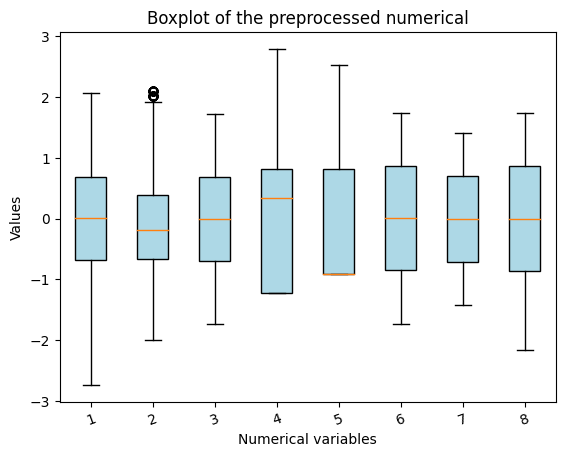

In [114]:
# showing the boxplot after preprocess
ploot = plt.boxplot(scaledOutRemEncoded[num_col], patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xticks(rotation=20)
plt.xlabel("Numerical variables")
plt.ylabel("Values")
plt.title("Boxplot of the preprocessed numerical")
plt.show()

In [115]:
df1 = scaledOutRemEncoded.drop('Exited', axis=1)
df2 = scaledOutRemEncoded[['Exited']]
preProcData = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
preProcData

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_1,IsActiveMember_1,Complain_1,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Exited
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,-0.721130,-0.630839,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,-0.009816,-0.666251,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,-0.009816,-1.015942,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,1.412812,-1.135457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,1.412812,-0.803472,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,1.246488,0.007457,-0.004426,-1.225848,0.807737,-0.066419,-1.432445,-1.356781,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
9511,-1.391939,-0.373958,1.724464,-0.306379,-0.911583,0.027988,1.412812,0.728088,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0
9512,0.604988,-0.278604,0.687130,-1.225848,-0.911583,-1.008643,-0.009816,-0.188192,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1
9513,1.256835,0.293517,-0.695982,-0.022608,0.807737,-0.125231,-0.721130,-1.184148,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1


In [116]:
# saving the prepreprocessed dataset
preProcData.to_csv('./DataSets/preprocessedData.csv', index=False)